In [1]:
# Setting the PythonPath
import os

# # Get the parent directory of the current working directory
parent_dir = os.path.dirname(os.getcwd())
if "changed" not in locals():
    changed = False

if not changed:
    os.chdir(parent_dir)
    changed = True
print(os.getcwd())

%load_ext autoreload
%autoreload 2

/home/local/USHERBROOKE/aara2601/projects/effective-efficient-qrc


# Problème d'apprentissage de fonctionnels

### La tâche consiste à apprendre la correspondance entre une window temporelle $W = (X_{t+1}, ..., X_{t+w})$ tirée d'une série temporelle $\mathrm{X} = (X_t : t \leq 0)$, et une valeure numérique $y \in \mathbb{R}$
### $$H^\ast: W \longmapsto y $$
<img src="figs/functional.png" width="800">

### Fonctionnels à apprendre: ceux qui respectent la propriété de mémoire évanescente (FMP)
<img src="figs/fading_memory_property.png" width="800">

#### Problème = apprendre un fonctionnel inconnu $H^\ast$ en minimisant le risque statistique $R(H) = \mathbb{E} [\ell(H(W), y)]$, où $\ell$ est une fonctionne d'erreur: MSE.

# Data

## Used processe and label functionals

#### Vector autoregressive-moving average: $VARMA(p,q) \implies \textrm{X} = (X_t : t \leq 0)$, where multi-dimensionality is used $X_t \in \mathbb{R}^d$
### $$X_t = \sum_{i=1}^p \Phi_i X_{t-i} + \sum_{j=1}^q \Theta_j \epsilon_{t-j} + \epsilon_t$$
#### $(\epsilon_t)_t$ are i.i.d errors, and $\Phi_i, \Theta_j$ are weight $d \times d$ matrices that are generated randomly and fixed for the whole process. 

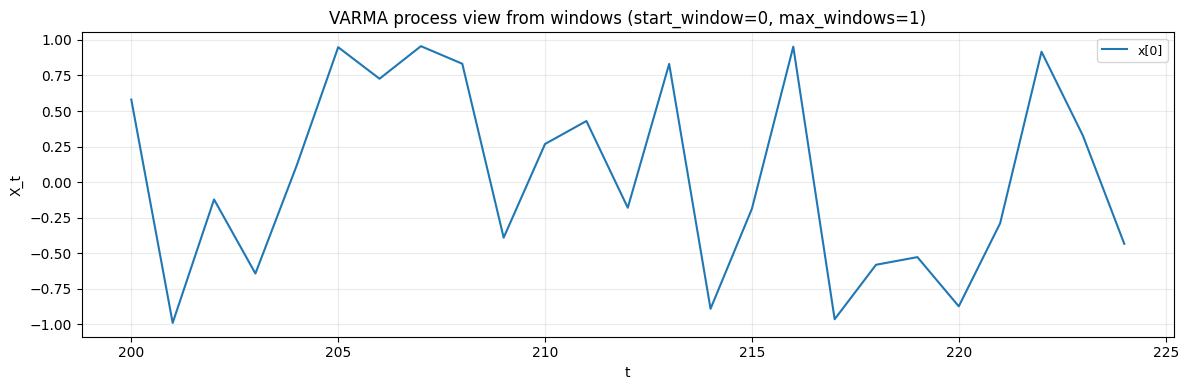

In [7]:
from src.viz.dataviz import ProcessVisualizer
from src.settings import STORAGE_PATH
from pathlib import Path

dataset_path = Path(STORAGE_PATH) / "data" / "synthetic" / "varma" / "N=10000__w=25__d=3__s=100"


viz = ProcessVisualizer(dataset_path).load()
fig = viz.plot_process(dims=[0], max_windows=1, x_axis="time", include_gaps=True)
fig.show()

#### We generate a number of $N = 1024$ windows $\mathcal{D} = \{W_1, ..., W_N\}$ where each window 
### $$W_i = (X_{t + 1}, ..., X_{t + w}). $$

#### The task is to learn using our quantum reservoir computer a functional $H^\ast(W) = y$.

## Label functionals used are the three following ones.

#### One step ahead forecasting functional
### $$y := H^\ast(W) :=  u^\top X_{t+w+1},$$
#### $u$ is some random fixed vector that projects to $\mathbb{R}$.

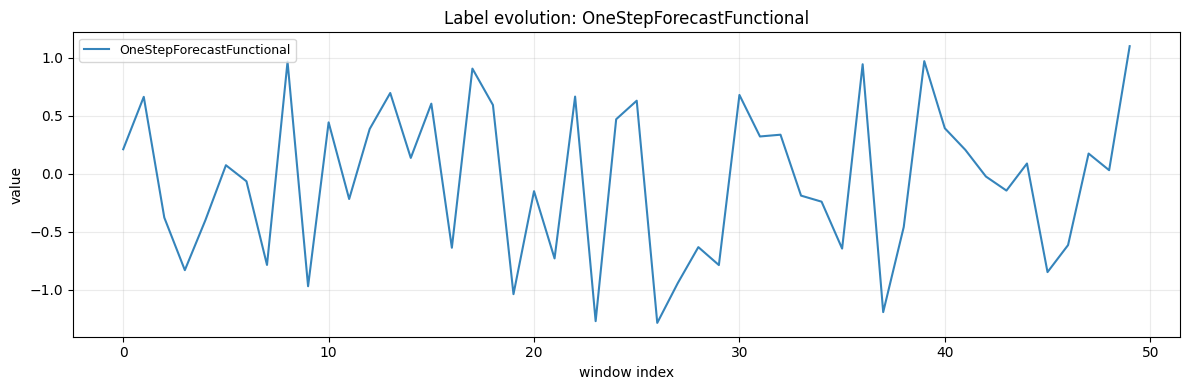

In [85]:
fig = viz.plot_tasks(
    task_indices=0,
    max_windows=50,
    select="first",
    x_axis="relative",
    input_summary="none",
    normalize="none",
    figsize=(12,4)
)
fig.show()


#### Hard linear Exponential Fading Linear functional. An exponentially fading smoothing window affect the prediction.
### $$y := H^\ast(W) := \sum_{k=0}^{w-1}\alpha^k\, u^\top X_{t-k},$$
#### $\alpha \in (0,1)$ is random and fixed weight.

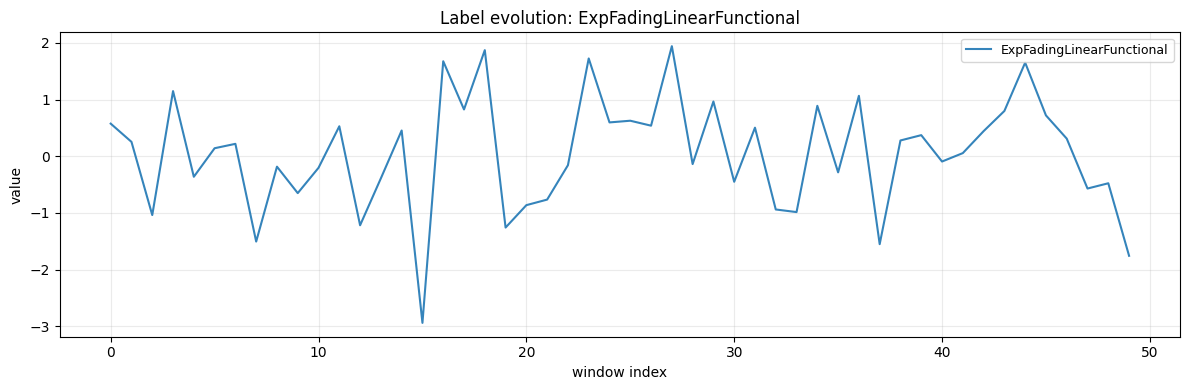

In [86]:
fig = viz.plot_tasks(
    task_indices=1,
    max_windows=50,
    select="first",
    x_axis="relative",
    input_summary="none",
    normalize="none",
    figsize=(12,4)
)
fig.show()

#### Harder non-linear: Voltera functional: different interactions affect the prediction.
### $$y = H^\ast(W) = \sum_{k=0}^{w-1}\alpha^k\, u^\top X_{t-k}
    \;+\; \frac{1}{2}\sum_{k=0}^{w-1}\sum_{\ell=0}^{w-1}\alpha^{k+\ell}\,
    (v^\top X_{t-k})(v^\top X_{t-\ell}),$$
#### with $v$ a random weight vector as well.

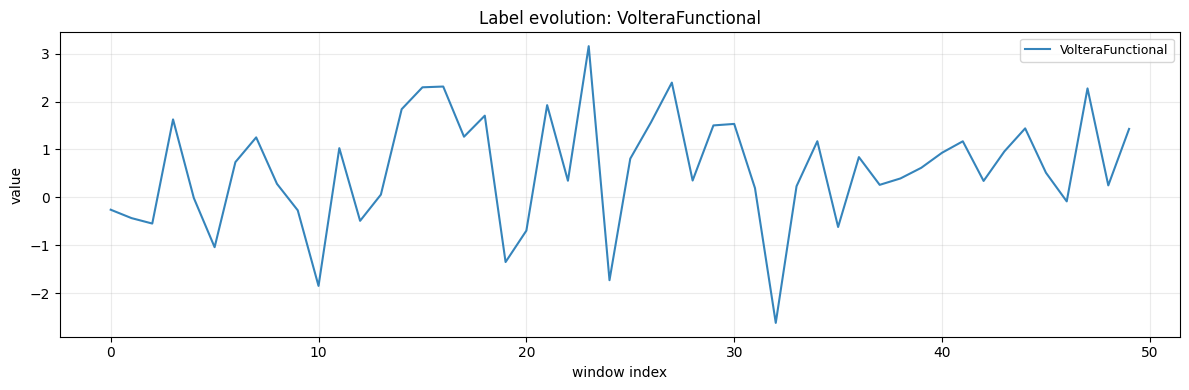

In [87]:
fig = viz.plot_tasks(
    task_indices=2,
    max_windows=50,
    select="first",
    x_axis="relative",
    input_summary="none",
    normalize="none",
    figsize=(12,4)
)
fig.show()

#### All labesl together

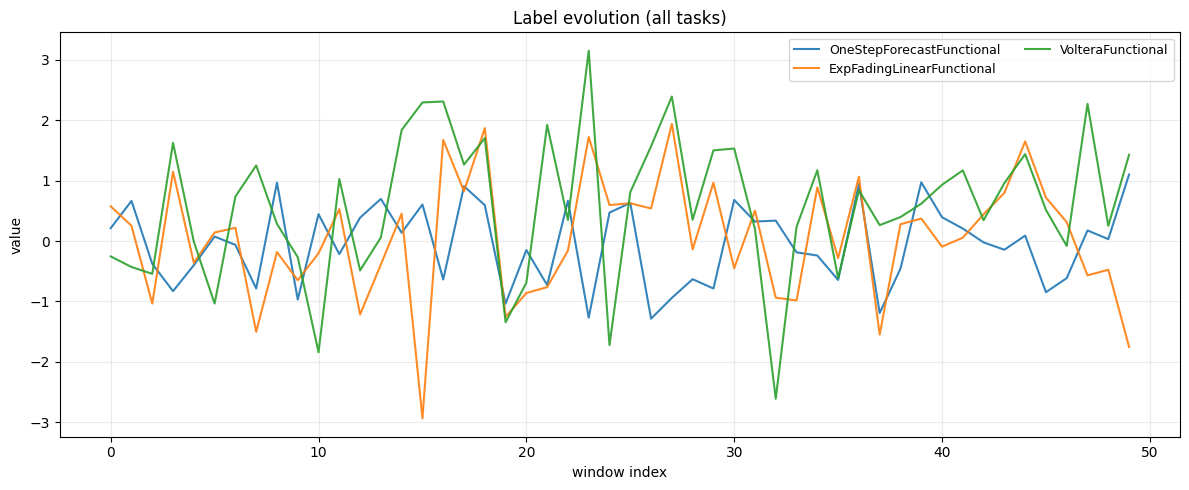

In [89]:
fig = viz.plot_tasks(
    task_indices=None,
    max_windows=50,
    select="first",
    x_axis="relative",
    input_summary="none",
    normalize="none",
)
fig.show()

# Predictions visualization

### Used a reservoir computer
<img src="figs/learning_with_QRCs.png" width="1000">


### Used quantum reservoir: 5 qubits.
<img src="figs/design.svg" width="1000">

#### Load the experiment

In [48]:
import os
from pathlib import Path

import numpy as np
from omegaconf import OmegaConf

from src.settings import STORAGE_PATH
from src.experiment.experiment import Experiment

# --- dataset path (yours) ---
dataset_path = (
    Path(STORAGE_PATH)
    / "data" / "synthetic" / "varma"
    / "N=10000__w=25__d=3__s=100"
)

# --- run directory (the timestamped folder in your screenshot) ---
run_dir = (
    Path(STORAGE_PATH)
    / "results" / "reg_sweep" / "c-shadows" / "full" / "N=10000__w=25__d=3__s=100" / "2026-02-02_14-02-13"
)

artifacts_dir = run_dir / "artifacts"

# 1) load hydra config used for that run (to reconstruct featurizer/model init)
cfg = OmegaConf.load(run_dir / ".hydra" / "config.yaml")

# 2) build Experiment with model instantiated from cfg
exp = Experiment.from_paths(
    dataset_path=dataset_path,
    model_cfg=cfg.model,                 # assumes top-level "model" in hydra config
    instantiate_functionals=True,
)

In [53]:
# 3) load trained model weights/arrays from disk and attach to exp
#    Keep the featurizer from cfg so you can call model.predict(X_new) if needed.
featurizer = getattr(exp.model, "featurizer", None)
exp.load_model(run_dir / "model", featurizer=featurizer)

,featurizer,QRCFeaturizer...seed': 12345})
,standardize,True
,test_ratio,0.2
,split_seed,0
,tuning,{}


In [54]:
# 4) (optional) also reload the sweep results saved by your script
npz_path = run_dir / "reg_sweep.npz"
if npz_path.exists():
    z = np.load(npz_path, allow_pickle=False)
    exp.reg_sweep_ = {k: z[k] for k in z.files}

print("Loaded:", exp.dataset.X.shape, np.asarray(exp.dataset.y).shape)
print("Model has Phi_full_:", exp.model.Phi_full_ is not None)

Loaded: (10000, 25, 3) (3, 10000)
Model has Phi_full_: True


### Effective training results

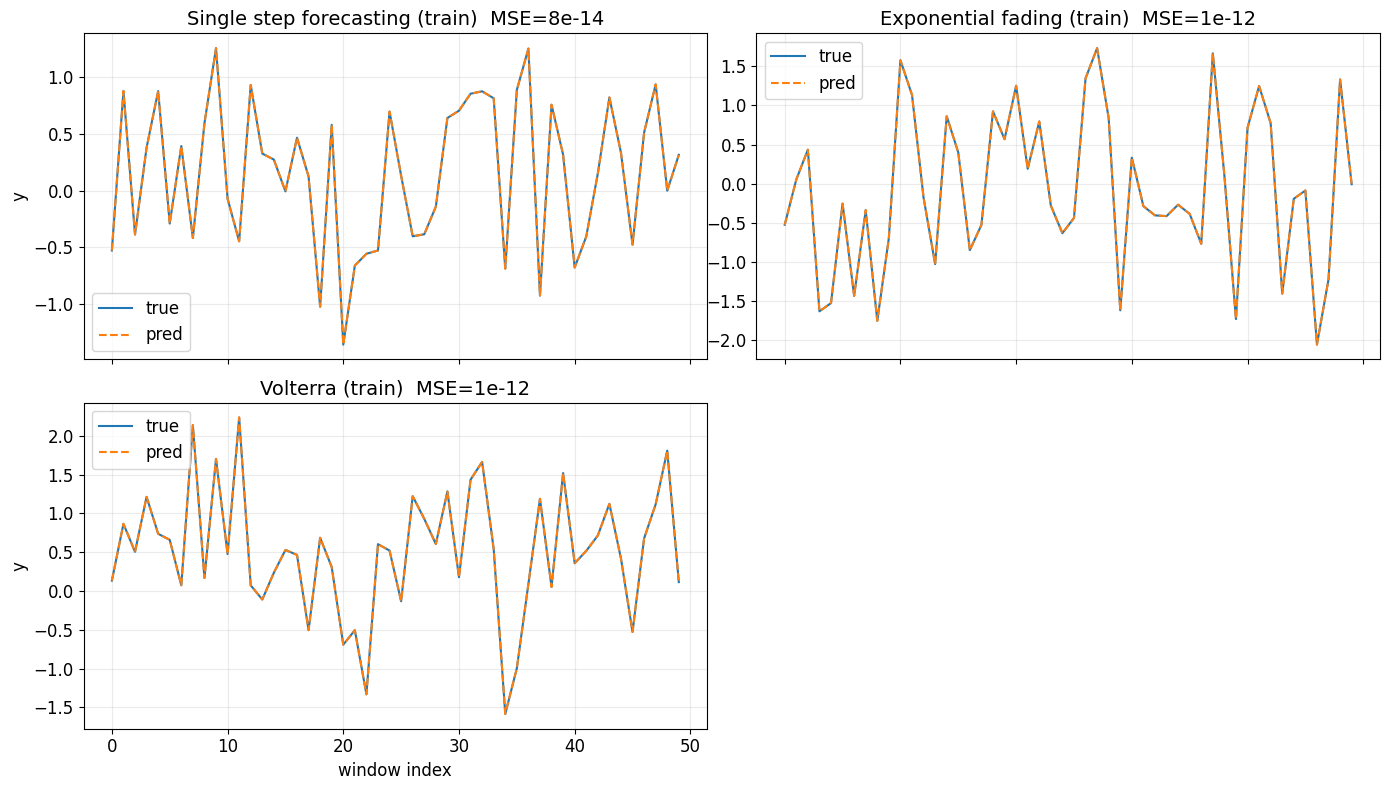

In [121]:
from src.viz.viz_pred import plot_true_vs_pred_grid
panel_titles=[
        "Single step forecasting",
        "Exponential fading",
        "Volterra"]



fig = plot_true_vs_pred_grid(exp, task_indices=[0,1,2], figsize=(14, 8), 
                             max_points=50, split="train", show_mse_in_title=True, 
                             panel_titles=panel_titles, x_axis="relative",
                             title_fontsize=14,
                             label_fontsize=12,
                             tick_fontsize=12,
                             legend_fontsize=12,
                            )

out_path = artifacts_dir / "true_vs_pred_grid_train.pdf"
fig.savefig(out_path, bbox_inches="tight")

fig.show()

### Generalization results

In [ ]:
#### Provide refitting using best lambda

# from src.experiment.exp_utils import select_lambda_via_train_val_per_task

# reg_grid = np.logspace(-10, 0, 41)

# sel = select_lambda_via_train_val_per_task(
#     exp,
#     reg_grid,
#     val_ratio=0.2,
#     split_strategy="random",  # for time-series this is often preferable
#     refit_on_full_train=True,
# )

# print("best λ per task:", sel["best_lambda_per_task"])

#### Sweep over different dataset sizes

In [78]:
from src.experiment.exp_utils import sweep_training_sizes_fixed_test

sizes = [100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 6000, 8000]
res = sweep_training_sizes_fixed_test(exp, sizes, lambda_regs=None, progress=True)  # pulls best lambdas from sweep

out_path = artifacts_dir / "train_size_sweep.pkl"

with open(out_path, "wb") as f:
    pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)

tasks: 100%|██████████████████████████████████████████████████████████████████████████████| 3/3 [03:06<00:00, 62.31s/it]


In [128]:
# import pickle

# out_path = artifacts_dir / "train_size_sweep.pkl"

# with open(out_path, "wb") as f:
#     pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)

In [129]:
with open(out_path, "rb") as f:
    res2 = pickle.load(f)

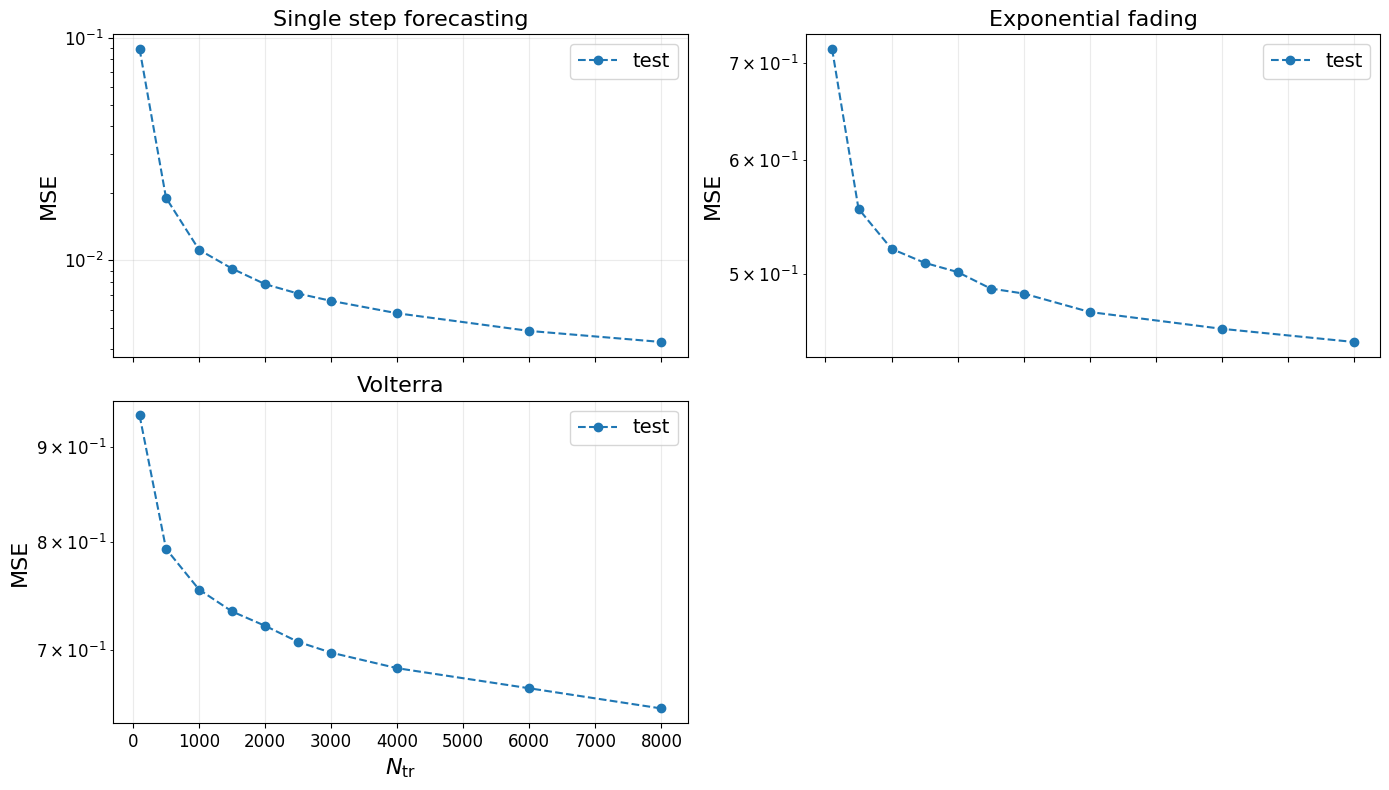

In [126]:
from src.viz.viz_pred import plot_mse_vs_train_size_grid

fig = plot_mse_vs_train_size_grid(
    res,
    exp=exp,
    split="test",
    panel_titles=["Single step forecasting", "Exponential fading", "Volterra"],
    y_scale="log",
    figsize=(14, 8), 
    title_fontsize=16,
    label_fontsize=16,
    tick_fontsize=12,
    legend_fontsize=14,
)

out_path = artifacts_dir / "test_mse_vs_varying_dataset_sizes.pdf"
fig.savefig(out_path, bbox_inches="tight")

fig.show()

#### Test plots

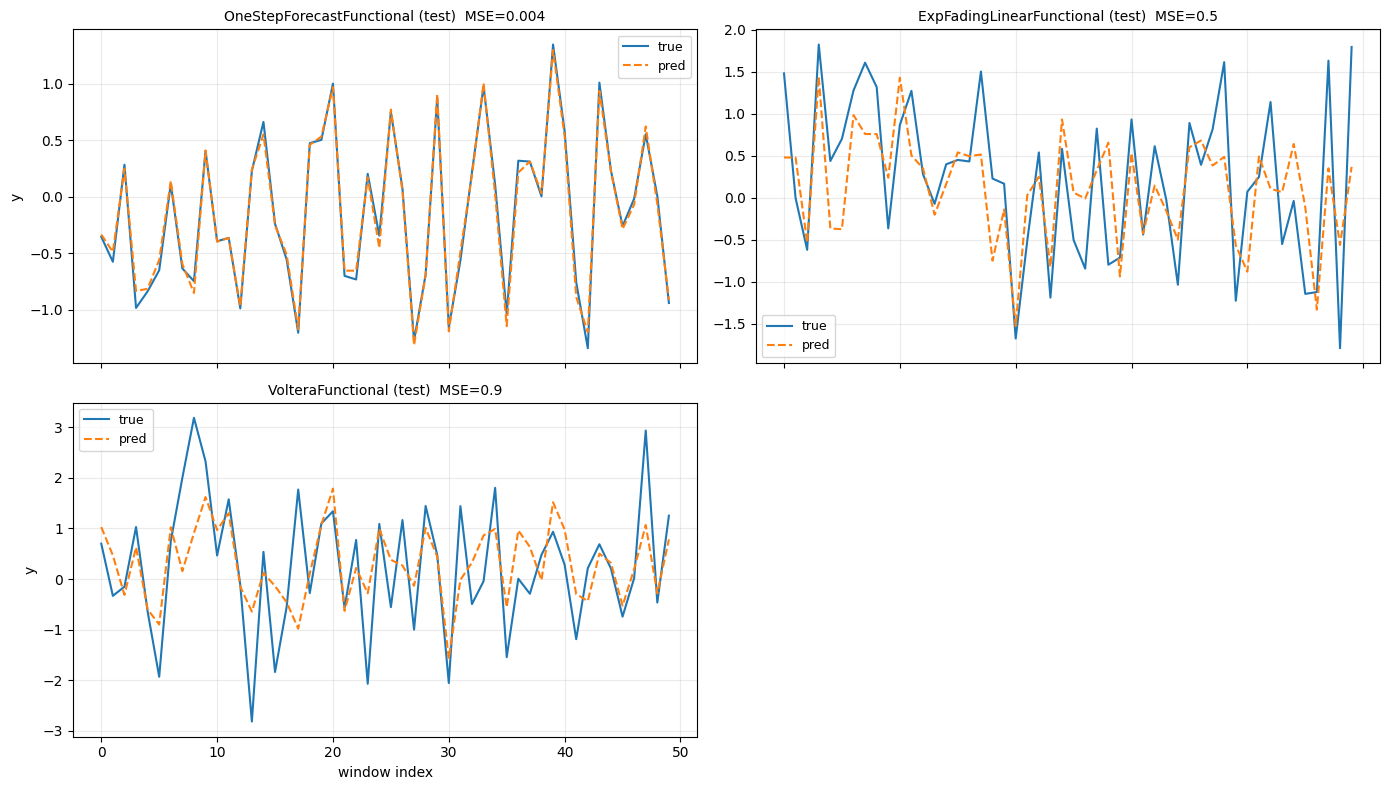

In [61]:
from src.viz.viz_pred import plot_true_vs_pred_grid

fig = plot_true_vs_pred_grid(exp, task_indices=[0,1,2], figsize=(14, 8), max_points=50, split="test", x_axis="relative")

fig.show()